# RoBERTa

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset
from transformers import RobertaTokenizer, RobertaModel, RobertaConfig
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, classification_report
import torch.nn as nn

In [3]:
# === Set random seed ===
np.random.seed(691)
torch.manual_seed(691)

In [4]:
# === Load data ===
train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/validation.csv")
test_df = pd.read_csv("data/test.csv")

target_col = 'label_id'
num_classes = train_df[target_col].nunique()

In [5]:
# === Define feature columns ===
categorical_cols = ['subject', 'speaker', 'party_affiliation', 'context']
numeric_cols = ['subject_count', 'readability_score', 'num_named_entities',
                'entity_types_present', 'has_citation_words',
                'polarity_shift_words_count', 'uncertainty_words_count',
                'negation_words_count', 'tfidf_score_sum', 'sentiment_score']

In [6]:
# === Label encoders for categorical features ===
cat_encoders = {}
num_categorical_feats_list = []
for col in categorical_cols:
    le = LabelEncoder()
    le.fit(pd.concat([train_df[col], val_df[col], test_df[col]]).astype(str))
    cat_encoders[col] = le
    num_categorical_feats_list.append(len(le.classes_))

In [7]:
# === Scale numeric features ===
scaler = StandardScaler()
scaler.fit(train_df[numeric_cols])
train_df[numeric_cols] = scaler.transform(train_df[numeric_cols])
val_df[numeric_cols] = scaler.transform(val_df[numeric_cols])
test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])

In [8]:
# === Tokenizer ===
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [9]:
# === Hybrid Dataset ===
class HybridRoBERTaDataset(Dataset):
    def __init__(self, df, tokenizer, cat_encoders, numeric_cols, max_len=128):
        self.texts = df['statement'].astype(str).tolist()
        self.labels = df[target_col].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

        # Categorical features
        self.categorical_feats = []
        for col, encoder in cat_encoders.items():
            encoded_col = encoder.transform(df[col].astype(str))
            self.categorical_feats.append(torch.tensor(encoded_col, dtype=torch.long))
        self.categorical_feats = torch.stack(self.categorical_feats, dim=1)

        # Numeric features
        self.numeric_feats = torch.tensor(df[numeric_cols].values, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['categorical_feats'] = self.categorical_feats[idx]
        item['numeric_feats'] = self.numeric_feats[idx]
        item['labels'] = torch.tensor(label, dtype=torch.long)

        return item

In [10]:
# === Datasets ===
train_ds = HybridRoBERTaDataset(train_df, tokenizer, cat_encoders, numeric_cols)
val_ds = HybridRoBERTaDataset(val_df, tokenizer, cat_encoders, numeric_cols)
test_ds = HybridRoBERTaDataset(test_df, tokenizer, cat_encoders, numeric_cols)

In [11]:
# === Data collator ===
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [12]:
# === Hybrid RoBERTa + Features model ===
class HybridRoBERTaClassifier(nn.Module):
    def __init__(self, num_categorical_feats_list, num_numeric_feats, num_classes, cat_embed_dim=16, roberta_model_name='roberta-base'):
        super().__init__()

        # RoBERTa backbone
        self.roberta = RobertaModel.from_pretrained(roberta_model_name)

        # Categorical embeddings
        self.cat_embeddings = nn.ModuleList([
            nn.Embedding(cat_size, cat_embed_dim) for cat_size in num_categorical_feats_list
        ])

        # Final FC layer
        roberta_hidden_dim = self.roberta.config.hidden_size
        total_input_dim = roberta_hidden_dim + num_numeric_feats + len(num_categorical_feats_list) * cat_embed_dim

        self.fc = nn.Sequential(
            nn.Linear(total_input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask, categorical_feats, numeric_feats, labels=None):
        # RoBERTa CLS token
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # CLS token

        # Categorical embeddings
        cat_embeds = []
        for i, embedding_layer in enumerate(self.cat_embeddings):
            cat_embed = embedding_layer(categorical_feats[:, i])
            cat_embeds.append(cat_embed)
        cat_embeds = torch.cat(cat_embeds, dim=1)

        # Combine features
        combined = torch.cat([cls_output, numeric_feats, cat_embeds], dim=1)

        logits = self.fc(combined)

        # Optional: compute loss if labels provided
        loss = None
        if labels is not None:
            # loss_fct = nn.CrossEntropyLoss(weight=class_weights_tensor.to(logits.device))
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, num_classes), labels.view(-1))

        return {'loss': loss, 'logits': logits}

In [13]:
# === Instantiate model ===
model = HybridRoBERTaClassifier(
    num_categorical_feats_list=num_categorical_feats_list,
    num_numeric_feats=len(numeric_cols),
    num_classes=num_classes
)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# === Compute metrics ===
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [15]:
# === TrainingArguments ===
training_args = TrainingArguments(
    output_dir="./roberta_hybrid_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir="./logs",
    report_to="none",
    save_total_limit=1
)

In [16]:
# === Custom Trainer ===
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [17]:
# === Train ===
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.751300,1.756058,0.256231,0.194553,0.201001,0.256231
2,1.705500,1.686963,0.269470,0.238199,0.280677,0.269470
3,1.653200,1.711704,0.269470,0.254861,0.269320,0.269470
4,1.520300,1.750084,0.268692,0.260199,0.268813,0.268692
5,1.412200,1.823520,0.246885,0.246769,0.255230,0.246885
6,1.324700,1.919289,0.255452,0.254158,0.257827,0.255452
7,1.244600,2.052538,0.262461,0.259766,0.267032,0.262461
8,1.070500,2.102381,0.251558,0.250456,0.256152,0.251558
9,1.010300,2.187356,0.259346,0.258459,0.262823,0.259346
10,0.950800,2.228478,0.268692,0.268064,0.273125,0.268692


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=6400, training_loss=1.3391671943664551, metrics={'train_runtime': 2761.9327, 'train_samples_per_second': 37.075, 'train_steps_per_second': 2.317, 'total_flos': 0.0, 'train_loss': 1.3391671943664551, 'epoch': 10.0})

In [18]:
# === Evaluate ===
print("\nValidation Set Evaluation:")
outputs_val = trainer.predict(val_ds)
trainer.evaluate(eval_dataset=val_ds)


Validation Set Evaluation:


{'eval_loss': 1.686963438987732,
 'eval_accuracy': 0.26947040498442365,
 'eval_f1': 0.2381985443968493,
 'eval_precision': 0.2806769278932326,
 'eval_recall': 0.26947040498442365,
 'eval_runtime': 7.7257,
 'eval_samples_per_second': 166.198,
 'eval_steps_per_second': 5.307,
 'epoch': 10.0}

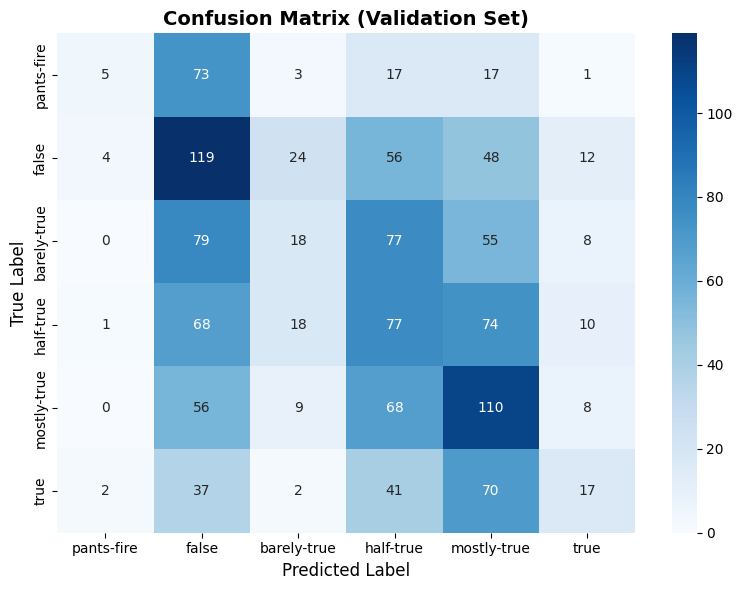

In [19]:
# Plot CM for validation set
val_logits = outputs_val.predictions
val_labels = outputs_val.label_ids
val_preds = np.argmax(val_logits, axis=1)

cm_val = confusion_matrix(val_labels, val_preds)
label_names = train_df[['label_id', 'label']].drop_duplicates().sort_values('label_id')['label'].tolist()

plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names,
            yticklabels=label_names)
plt.title("Confusion Matrix (Validation Set)", fontsize=14, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()

In [20]:
# === Evaluate ===
print("\nTest Set Evaluation:")
outputs_test = trainer.predict(test_ds)
trainer.evaluate(eval_dataset=test_ds)


Test Set Evaluation:


{'eval_loss': 1.68952476978302,
 'eval_accuracy': 0.2825572217837411,
 'eval_f1': 0.2553061944083834,
 'eval_precision': 0.3190000848974897,
 'eval_recall': 0.2825572217837411,
 'eval_runtime': 7.9162,
 'eval_samples_per_second': 160.052,
 'eval_steps_per_second': 5.053,
 'epoch': 10.0}

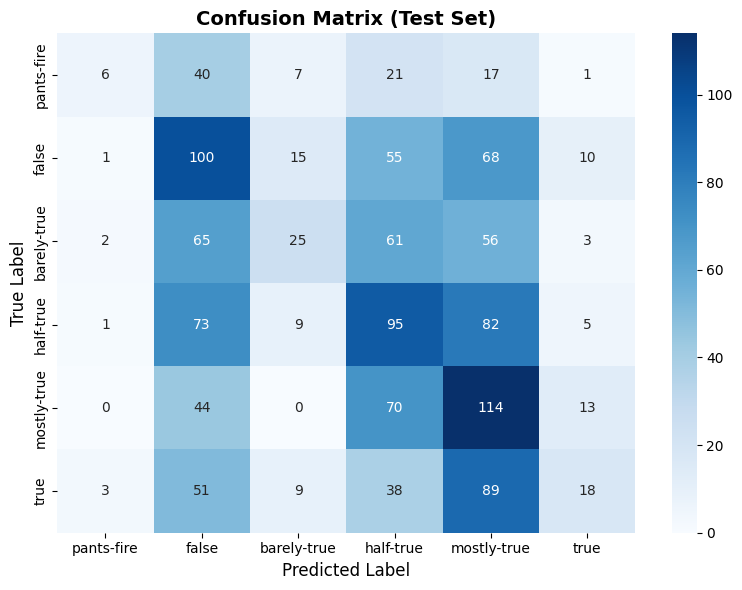

In [21]:
# Plot CM for test set
test_logits = outputs_test.predictions
test_labels = outputs_test.label_ids
test_preds = np.argmax(test_logits, axis=1)

cm_test = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names,
            yticklabels=label_names)
plt.title("Confusion Matrix (Test Set)", fontsize=14, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()

---